In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# === Configuration ===
RESULT_DIR = Path("result/yearly-main")
MODEL = "gpt-4o"
YEARS = list(range(2013, 2023))
LABELS = list("ABCDEFG")
LABELS = list("ABCDEFG")

LABEL_COLORS = {
    "A": "#1f77b4",  # muted blue
    "B": "#ff7f0e",  # orange
    "C": "#2ca02c",  # green
    "D": "#d62728",  # red
    "E": "#9467bd",  # purple
    "F": "#8c564b",  # brown
    "G": "#e377c2",  # pink
}
# === Load & Combine Data ===
dfs = []
for year in YEARS:
    file_path = RESULT_DIR / f"labelled_{MODEL}_{year}_sample100.csv"
    if file_path.exists():
        df = pd.read_csv(file_path)
        df["year"] = year
        dfs.append(df)
    else:
        print(f"⚠️ Missing file: {file_path}")

all_data = pd.concat(dfs, ignore_index=True)


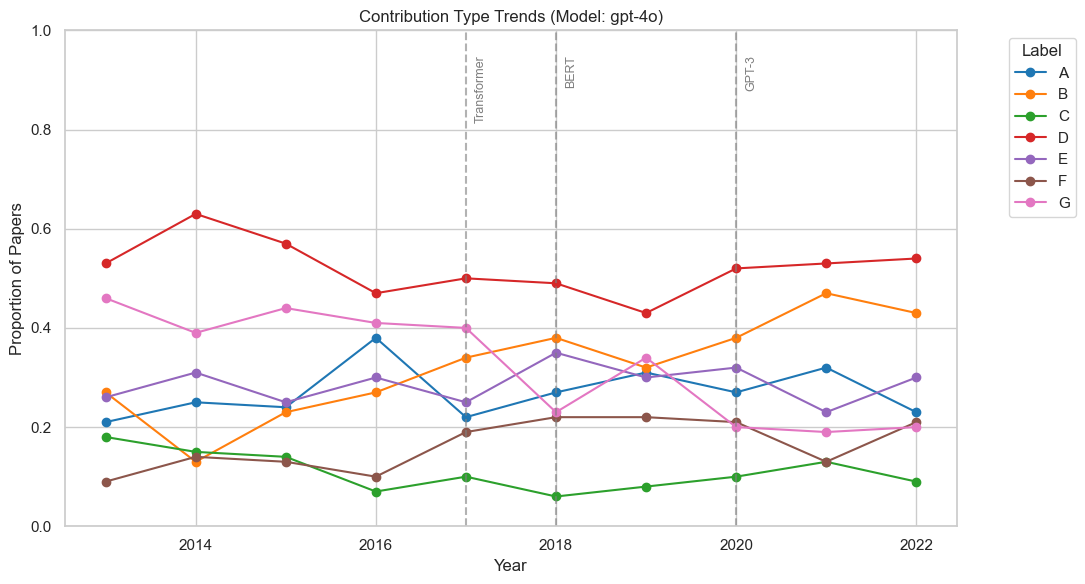

In [25]:
# === Compute mean and standard error for each label per year ===
summary = (
    all_data.groupby("year")[LABELS]
    .agg(['mean', 'sem'])  # mean and standard error
)

# === Reshape into long-form for seaborn plotting ===
plot_df = []
for label in LABELS:
    for year in summary.index:
        plot_df.append({
            "year": year,
            "Label": label,
            "Proportion": summary.loc[year][(label, 'mean')],
            "SE": summary.loc[year][(label, 'sem')]
        })
plot_df = pd.DataFrame(plot_df)

# === Plot with confidence intervals ===
plt.figure(figsize=(11, 6))
sns.set_theme(style="whitegrid")

for label in LABELS:
    df_label = plot_df[plot_df["Label"] == label]
    plt.plot(df_label["year"], df_label["Proportion"], color=LABEL_COLORS[label], marker="o", label=label)
    # plt.fill_between(
    #     df_label["year"],
    #     df_label["Proportion"] - df_label["SE"],
    #     df_label["Proportion"] + df_label["SE"],
    #     alpha=0.2
    # )

# === Add milestone year lines ===
milestones = {
    2017: "Transformer",
    2018: "BERT",
    2020: "GPT-3"
}
for year, label in milestones.items():
    plt.axvline(x=year, color="gray", linestyle="--", alpha=0.6)
    plt.text(year + 0.1, 0.95, label, rotation=90, verticalalignment='top', fontsize=9, color="gray")

plt.title(f"Contribution Type Trends (Model: {MODEL})")
plt.xlabel("Year")
plt.ylabel("Proportion of Papers")
plt.ylim(0, 1)
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


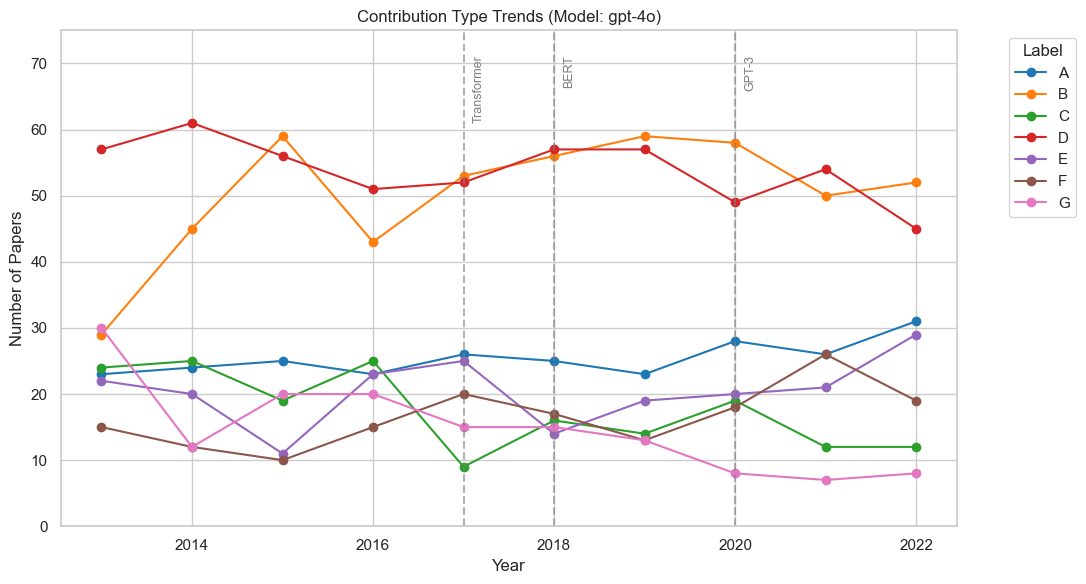

In [30]:
# === Compute total counts for each label per year ===
summary = (
    all_data.groupby("year")[LABELS]
    .sum()  # Sum the counts for each label
)

# === Reshape into long-form for seaborn plotting ===
plot_df = []
for label in LABELS:
    for year in summary.index:
        plot_df.append({
            "year": year,
            "Label": label,
            "Count": summary.loc[year, label]
        })
plot_df = pd.DataFrame(plot_df)

# === Plot the number of papers ===
plt.figure(figsize=(11, 6))
sns.set_theme(style="whitegrid")

for label in LABELS:
    df_label = plot_df[plot_df["Label"] == label]
    plt.plot(df_label["year"], df_label["Count"], color=LABEL_COLORS[label], marker="o", label=label)

# === Add milestone year lines ===
milestones = {
    2017: "Transformer",
    2018: "BERT",
    2020: "GPT-3"
}
for year, label in milestones.items():
    plt.axvline(x=year, color="gray", linestyle="--", alpha=0.6)
    plt.text(year + 0.1, 75 * 0.95, label, rotation=90, verticalalignment='top', fontsize=9, color="gray")

plt.title(f"Contribution Type Trends (Model: {MODEL})")
plt.xlabel("Year")
plt.ylabel("Number of Papers")
plt.ylim(0, 75)  # Set the maximum y-axis limit to 75
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


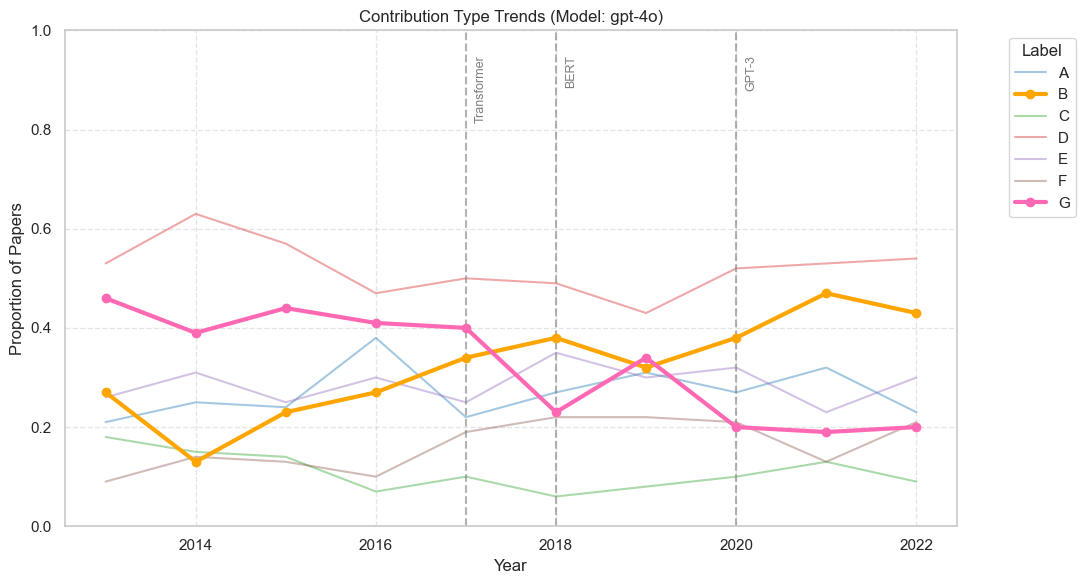

In [3]:
# === Plot without CI and with highlighted 'B' ===
plt.figure(figsize=(11, 6))
sns.set_theme(style="whitegrid")

for label in LABELS:
    df_label = plot_df[plot_df["Label"] == label]
    if label == "B":
        plt.plot(df_label["year"], df_label["Proportion"],
                 label="B", color="orange", linewidth=3, marker="o", zorder=5)
    elif label == "G":
        plt.plot(df_label["year"], df_label["Proportion"],
             label="G", color="hotpink", linewidth=3, marker="o", zorder=5)
    else:
        plt.plot(df_label["year"], df_label["Proportion"],
                 label=label, color=LABEL_COLORS[label], linewidth=1.5, linestyle="-", alpha=0.4)

# === Milestone year markers ===
milestones = {
    2017: "Transformer",
    2018: "BERT",
    2020: "GPT-3"
}
for year, label in milestones.items():
    plt.axvline(x=year, color="gray", linestyle="--", alpha=0.6)
    plt.text(year + 0.1, 0.95, label, rotation=90, verticalalignment='top', fontsize=9, color="gray")

plt.title(f"Contribution Type Trends (Model: {MODEL})")
plt.xlabel("Year")
plt.ylabel("Proportion of Papers")
plt.ylim(0, 1)
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


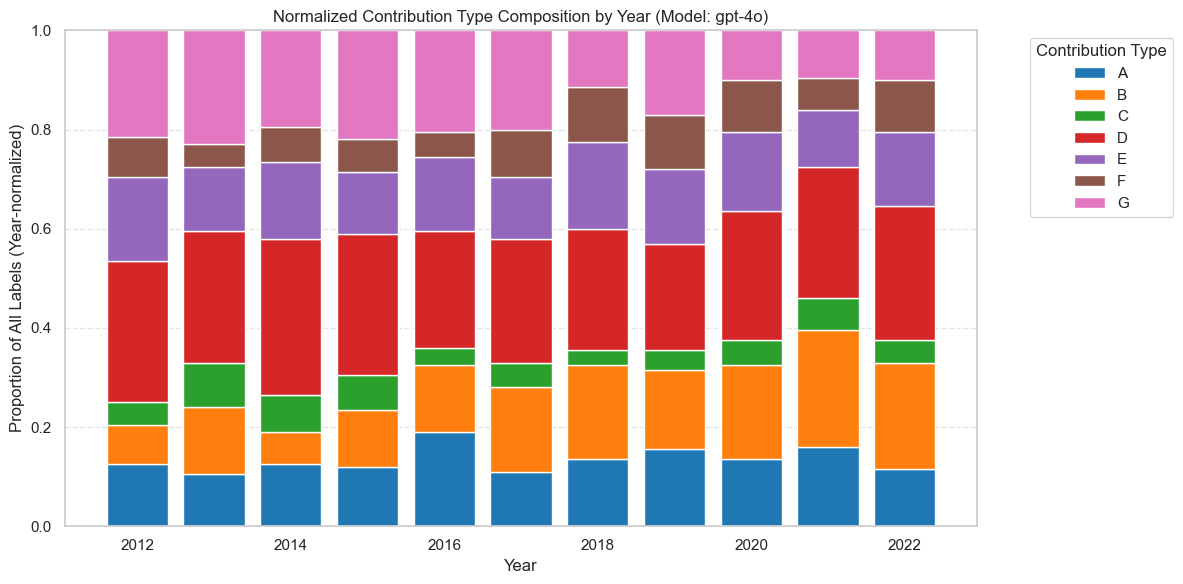

In [29]:
# === Compute normalized proportions (row-wise) ===
label_counts = (
    all_data.groupby("year")[LABELS]
    .sum()
    .reset_index()
    .set_index("year")
)

normalized = label_counts.div(label_counts.sum(axis=1), axis=0)

# === Plot ===
plt.figure(figsize=(12, 6))
bottom = None

for label in LABELS:
    plt.bar(
        normalized.index,
        normalized[label],
        bottom=bottom,
        label=label,
        color=LABEL_COLORS[label]
    )
    bottom = normalized[label] if bottom is None else bottom + normalized[label]

plt.title(f"Normalized Contribution Type Composition by Year (Model: {MODEL})")
plt.ylabel("Proportion of All Labels (Year-normalized)")
plt.xlabel("Year")
plt.ylim(0, 1)
plt.legend(title="Contribution Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

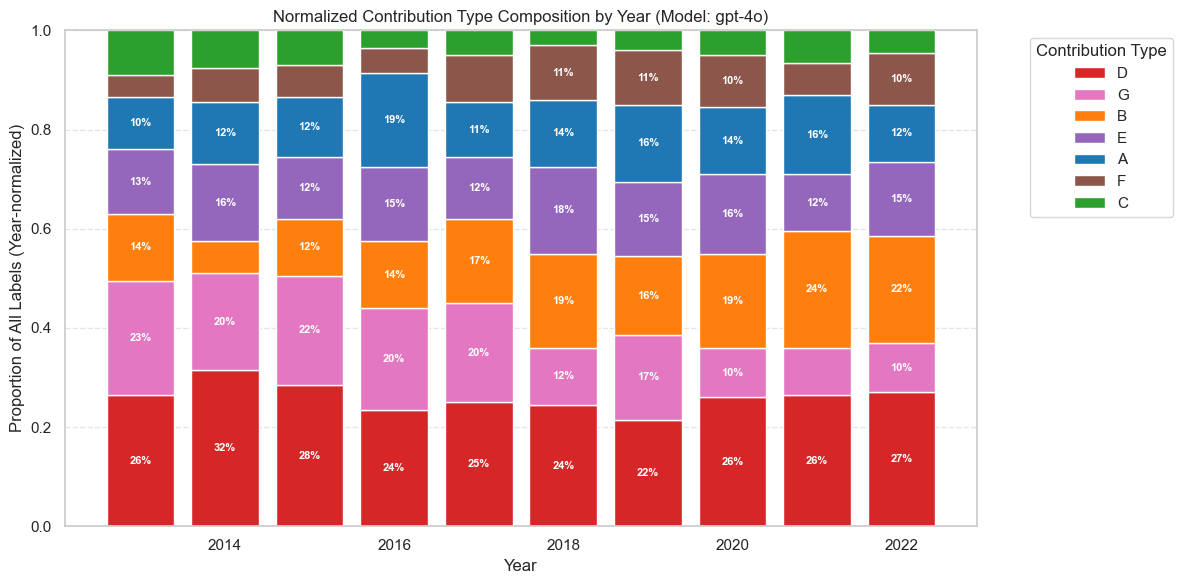

In [4]:
# === Sum raw label counts per year ===
label_counts = (
    all_data.groupby("year")[LABELS]
    .sum()
    .reset_index()
    .set_index("year")
)

# === Compute global label order (most common first) ===
label_order = label_counts.sum().sort_values(ascending=False).index.tolist()

# === Normalize each year's label distribution ===
normalized = label_counts.div(label_counts.sum(axis=1), axis=0)

# === Plot ===
plt.figure(figsize=(12, 6))
bottom = pd.Series([0] * len(normalized), index=normalized.index)

for label in label_order:
    bar = plt.bar(
        normalized.index,
        normalized[label],
        bottom=bottom,
        label=label,
        color=LABEL_COLORS[label],
    )

    # === Annotate proportions ≥ 10% ===
    for rect, yval in zip(bar, normalized[label]):
        if yval >= 0.1:
            plt.text(
                rect.get_x() + rect.get_width() / 2,
                rect.get_y() + rect.get_height() / 2,
                f"{yval:.0%}",
                ha="center", va="center", fontsize=8, color="white", weight="bold"
            )

    bottom += normalized[label]

plt.title(f"Normalized Contribution Type Composition by Year (Model: {MODEL})")
plt.ylabel("Proportion of All Labels (Year-normalized)")
plt.xlabel("Year")
plt.ylim(0, 1)
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.legend(title="Contribution Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()
